# Лабораторна робота №3

## Підключення бібліотек

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## Параметри для генерації даних та побудови дерев

In [35]:
RANDOM_STATE = 56
CRITERION = 'gini'
CLASS_WEIGHT = None

## Завантаження даних

In [36]:
df = pd.read_csv('./MFPD.csv')
print(f'розподіл для {df["fail"].value_counts()}')
df.head()

розподіл для fail
0    551
1    393
Name: count, dtype: int64


,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


## Розбиваємо дані на тренувальні та тестові

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['fail']),
    df['fail'],
    test_size=0.3,
    random_state=RANDOM_STATE
)

## Створення дерева та тренування

In [38]:
clf = DecisionTreeClassifier(criterion=CRITERION, class_weight=CLASS_WEIGHT, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=56)

## Тестування

In [39]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       161
           1       0.85      0.76      0.81       123

    accuracy                           0.84       284
   macro avg       0.84      0.83      0.84       284
weighted avg       0.84      0.84      0.84       284



## Візуалізація дерева

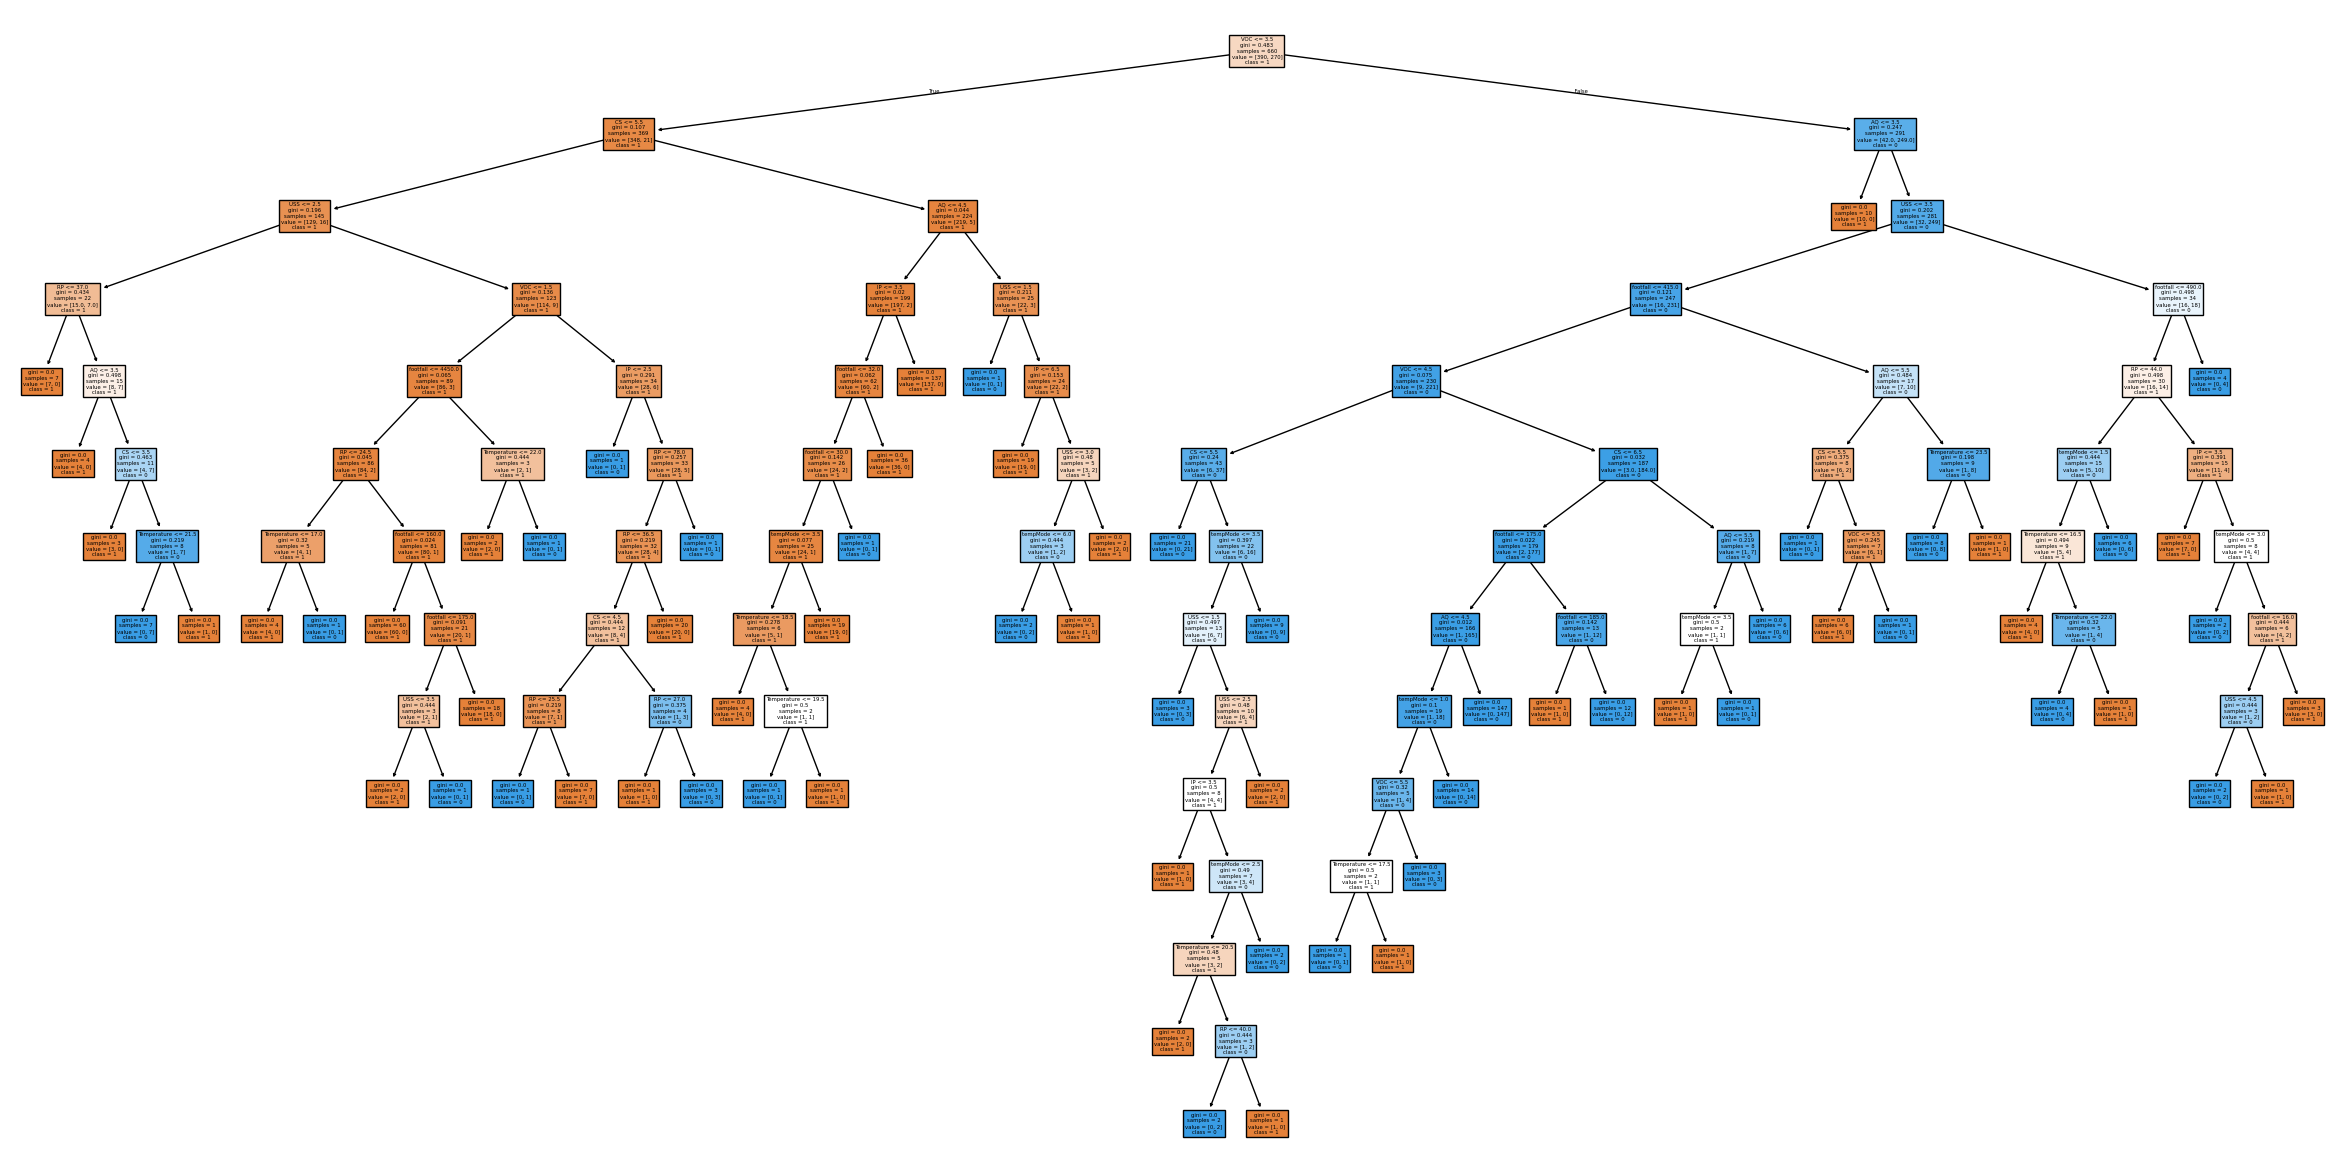

In [40]:
size = 15
plt.figure(figsize=(size*2, size))
tree.plot_tree(clf, filled=True, feature_names=df.columns, class_names=[str(x) for x in df['fail'].unique()])
plt.show()

# Відсікання зайвих гілок

## Обрахунок кращого параметра a для дерева

In [41]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas
alphas = alphas[:-1]

train_scores = []
test_scores = []

for alpha in alphas:
    clf_pruned = DecisionTreeClassifier(
        criterion=CRITERION,
        class_weight=CLASS_WEIGHT,
        random_state=RANDOM_STATE,
        ccp_alpha=alpha
    )
    clf_pruned.fit(X_train, y_train)

    train_scores.append(clf_pruned.score(X_train, y_train))
    test_scores.append(clf_pruned.score(X_test, y_test))

best_alpha_idx = np.argmax(test_scores)
best_alpha = alphas[best_alpha_idx]
print(f"накращий a={best_alpha}")

накращий a=0.022976583162957268


## Створення покращеного дерева

In [42]:
final_clf = DecisionTreeClassifier(
    criterion=CRITERION,
    class_weight=CLASS_WEIGHT,
    random_state=RANDOM_STATE,
    ccp_alpha=best_alpha
)
final_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.022976583162957268, random_state=56)

## Тестування обсіченого дерева

In [45]:
y_pred_final = final_clf.predict(X_test)
print("Final Pruned Tree Performance:")
print(classification_report(y_test, y_pred_final, zero_division=0))

Final Pruned Tree Performance:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       161
           1       0.88      0.91      0.89       123

    accuracy                           0.90       284
   macro avg       0.90      0.91      0.90       284
weighted avg       0.91      0.90      0.91       284



## Візуалізація

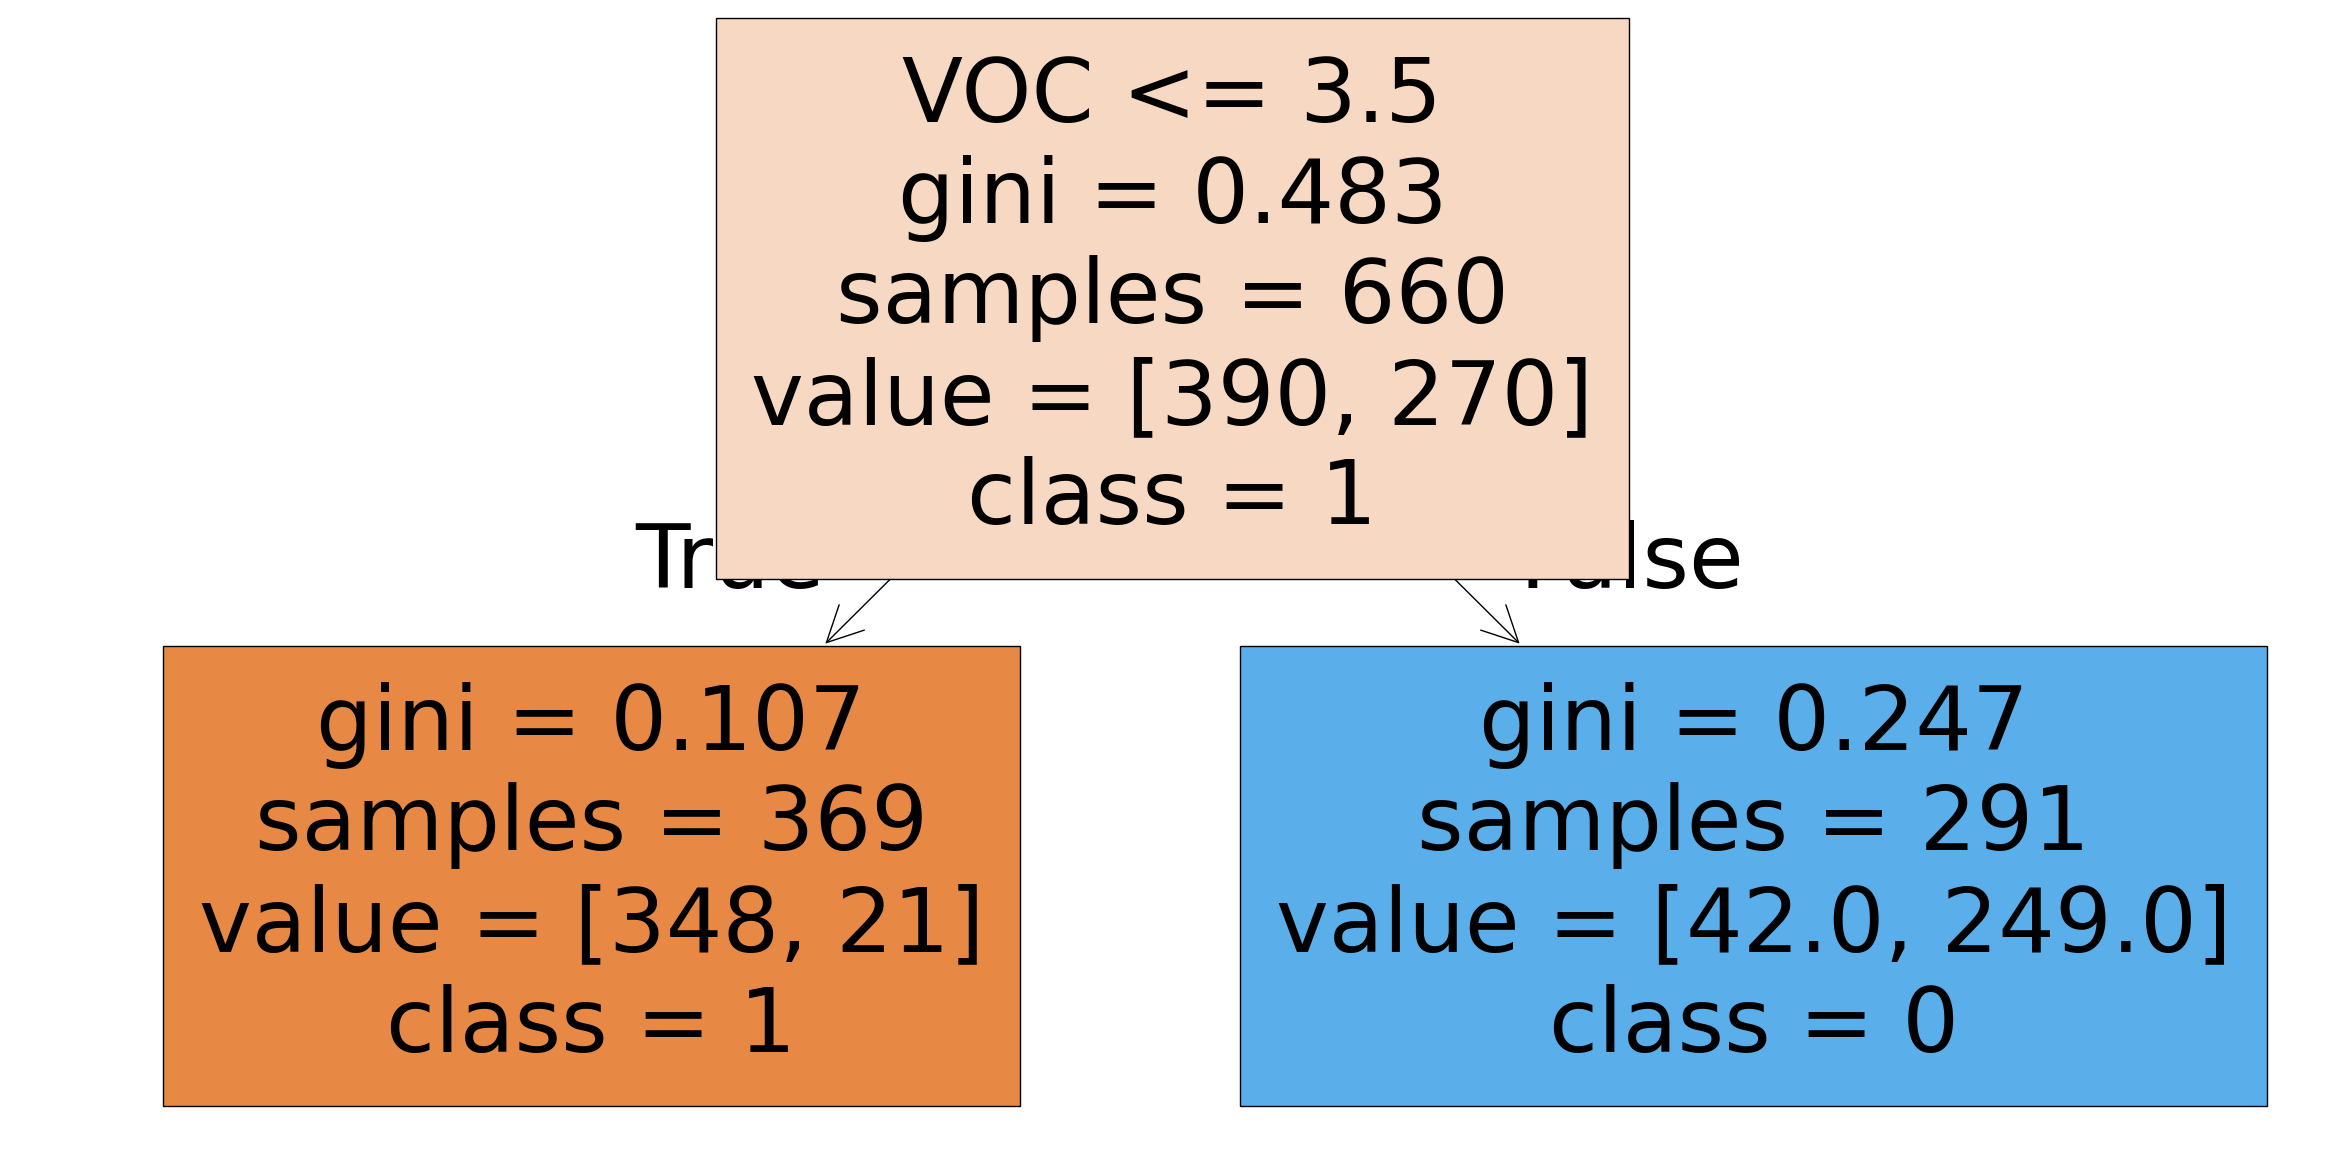

In [44]:
plt.figure(figsize=(size*2, size))
tree.plot_tree(final_clf, filled=True, feature_names=df.columns[:-1], class_names=[str(x) for x in df['fail'].unique()])
plt.show()